In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [54]:
import numpy as np
from numpy import linspace, sin, cos
from copy import copy
import matplotlib.pyplot as plt
from celluloid import Camera
from IPython.display import HTML

def simulate(Δt, x, u, l1, l2, m1, m2):
    θ1, θ2, θ1_dot, θ2_dot = x
    

    M = np.array([
        [l1**2 * (m1 + m2) + 2 * l1 * l2 * m2 * cos(θ2) + l2**2 * m2, 
         l2 * m2 * (l1 * cos(θ2) + l2)],
        [l2 * m2 * (l1 * cos(θ2) + l2), 
         l2**2 * m2]
    ])
    
    θ_ddot = np.linalg.inv(M).dot(u * np.array([0, 1]))
    
    x += Δt * np.concatenate((x[2:], θ_ddot))
    return x

# Parameters
l1, l2 = 2, 1     # Lengths of the pendulum arms
m1, m2 = 1, 1     # Masses
g = 9.8           # Gravity

# Time settings
tf = 6.
Δt = 0.1    # Time step
time = np.linspace(0., tf, int(tf / Δt) + 1)  # Time interval

# Initial conditions
#θ1, θ2, θ1_dot, θ2_dot = 0.2, np.pi/4, 0, 0
θ1, θ2, θ1_dot, θ2_dot = np.pi/2, -np.pi*2/3, 0, 0
x = np.array([θ1, θ2, θ1_dot, θ2_dot])
x_log = [copy(x)]

for t in time[1:]:
    # Control input
    u = 0.2

    # Simulate
    x = simulate(Δt, x, u, l1, l2/2, m1, m2)
    x_log.append(copy(x))

x_log = np.array(x_log)


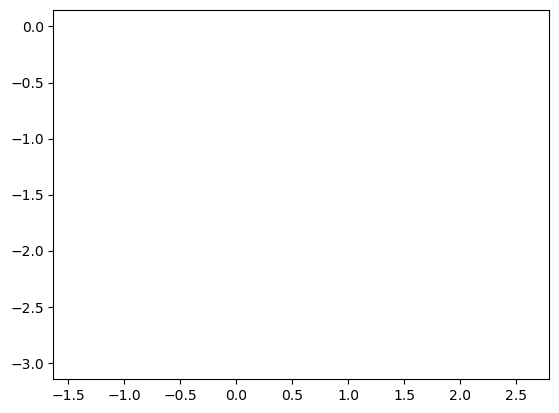

In [55]:
# Visualization using celluloid
fig, ax = plt.subplots()
camera = Camera(fig)

ax.set_xlim(-2 * (l1 + l2/2), 2 * (l1 + l2/2))
ax.set_ylim(-2 * (l1 + l2/2), 2 * (l1 + l2/2))

for frame in x_log:
    θ1, θ2, _, _ = frame
    x1, y1 = l1 * cos(θ1), -l1 * sin(θ1)
    x2, y2 = x1 + l2 * cos(θ1 + θ2), y1 - l2 * sin(θ1 + θ2)
    ax.plot([0, x1, x2], [0, y1, y2], 'ro-', lw=2)
    
    
    # Draw the arrow at the midpoint of the second pendulum arm
    arrow_x, arrow_y = (x1 + x2) / 2, (y1 + y2) / 2
    ax.quiver(arrow_x, arrow_y, -sin(θ1 + θ2), -cos(θ2 + θ1), angles='xy', scale_units='xy', scale=2, color='blue')
    ax.axis('equal')
    camera.snap()

animation = camera.animate()

display(HTML(animation.to_jshtml()))

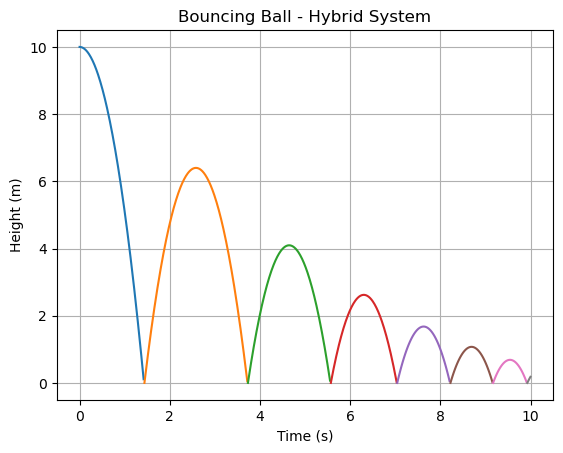

In [57]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Parameters
g = 9.81    # Acceleration due to gravity (m/s^2)
e = 0.8     # Coefficient of restitution (for bounce)

# Continuous dynamics (ball falling under gravity)
def free_fall(t, y):
    return [y[1], -g]

# Discrete dynamics (bounce)
def bounce(t, y):
    y[1] = -e * y[1]
    return y

# Simulation parameters
t_max = 10  # Total simulation time (s)
dt = 0.01   # Time step for checking events (s)

# Initial conditions
y0 = [10, 0]  # Initial height (m) and velocity (m/s)

# Event function to detect when the ball hits the ground
def hit_ground(t, y):
    return y[0]

hit_ground.terminal = True
hit_ground.direction = -1

# Main simulation loop
solution = []
t_span = [0, t_max]
while t_span[0] < t_max:
    t_eval = np.arange(t_span[0], t_span[1], dt)  # Update t_eval for the current time span
    sol = solve_ivp(free_fall, t_span, y0, t_eval=t_eval, events=hit_ground)
    solution.append(sol)
    
    if sol.t_events[0].size == 0:
        break
    y0 = bounce(sol.t_events[0], [sol.y_events[0][0, 0], sol.y_events[0][0, 1]])
    t_span = [sol.t_events[0][0] + dt, t_max]

# Plotting the results
plt.figure()
for sol in solution:
    plt.plot(sol.t, sol.y[0])
plt.xlabel('Time (s)')
plt.ylabel('Height (m)')
plt.title('Bouncing Ball - Hybrid System')
plt.grid(True)
plt.show()
